In [2]:
# all imports here
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools # all imports here
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kurtosis
import seaborn as sns

#### Reading Data
bnus_spot_btc_usd = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
bnus_spot_btc_usdc = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
bnus_spot_btc_usdt = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

cbse_spot_btc_usd = pd.read_csv('../Data/ohlcv_1s_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
cbse_spot_btc_usdt = pd.read_csv('../Data/ohlcv_1s_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

trades_bnus_btc_usd = pd.read_csv('../Data/trades_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_bnus_btc_usdc = pd.read_csv('../Data/trades_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_bnus_btc_usdt = pd.read_csv('../Data/trades_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

trades_cbse_btc_usd = pd.read_csv('../Data/trades_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_cbse_btc_usdt = pd.read_csv('../Data/trades_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
#### Approach 1 - normal standardization
print("Standardizing timestamps and indexing...")
ohlcv_dfs = [bnus_spot_btc_usd, bnus_spot_btc_usdc, bnus_spot_btc_usdt, 
             cbse_spot_btc_usd, cbse_spot_btc_usdt]

for df in ohlcv_dfs:
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)


print("Merging Binance data for Basis Calculation...")
#master df
df_analysis = pd.DataFrame(index=bnus_spot_btc_usd.index)

# Join the 'close' prices. 
# We use 'outer' join and 'ffill' (forward fill) because crypto markets 
# have empty seconds. If no trade happened at 12:00:05, we assume the 
# price remained the same as 12:00:04.
df_analysis['btc_usd'] = bnus_spot_btc_usd['close']
df_analysis = df_analysis.join(bnus_spot_btc_usdc['close'].rename('btc_usdc'), how='outer').ffill()
df_analysis = df_analysis.join(bnus_spot_btc_usdt['close'].rename('btc_usdt'), how='outer').ffill()

# Drop any remaining NaNs at the very beginning of the series
df_analysis.dropna(inplace=True)


print("Calculating Implied Pegs and Cross-Currency Basis...")

# 1. The Implied Stablecoin Rate 2 
# If BTC is $20k in USD, but $22k in USDC, 1 USDC = $0.90
df_analysis['implied_usdc'] = df_analysis['btc_usd'] / df_analysis['btc_usdc']
df_analysis['implied_usdt'] = df_analysis['btc_usd'] / df_analysis['btc_usdt']

# 2. The Cross-Currency Basis in Basis Points 1 
# How much of a premium/discount are you paying by using a stablecoin?
df_analysis['basis_usdc_bps'] = ((df_analysis['btc_usdc'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000
df_analysis['basis_usdt_bps'] = ((df_analysis['btc_usdt'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000


# VISUALIZE THE SVB CRASH
print("Plotting the De-peg event...")
plt.figure(figsize=(14, 7))

# Plot the calculated stablecoin values
plt.plot(df_analysis.index, df_analysis['implied_usdc'], label='Implied USDC Value', color='red', linewidth=1.5)
plt.plot(df_analysis.index, df_analysis['implied_usdt'], label='Implied USDT Value', color='green', linewidth=1, alpha=0.7)

# Draw the $1.00 "Peg" line
plt.axhline(1.0, color='black', linestyle='--', label='Theoretical Peg ($1.00)')

# Formatting
plt.title('Implied Stablecoin Values Derived from Spot Crypto Markets (March 2023)', fontsize=14)
plt.ylabel('Implied Value in USD', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print out the worst moment of the crash
worst_usdc = df_analysis['implied_usdc'].min()
worst_time = df_analysis['implied_usdc'].idxmin()
print(f"\n--- CRITICAL FINDING ---")
print(f"The lowest implied value of USDC was ${worst_usdc:.4f} occurring on {worst_time}")
print("Aligning data to a continuous 1-second grid...")

#21 day window
master_index = pd.date_range("2023-03-01 00:00:00", "2023-03-21 23:59:59", freq='1s', tz='UTC')

def clean_df(df):
    """Sets the timestamp column as index, aligns to master grid, and fills gaps."""
    df_clean = df.copy() 
    
    # 1. Properly parse the timestamp to avoid the 1970 nanosecond bug
    if 'timestamp' in df_clean.columns:
        if pd.api.types.is_numeric_dtype(df_clean['timestamp']):
            # If it's a number, it's a Unix timestamp in milliseconds
            df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], unit='ms', utc=True)
        else:
            # If it's already a date string
            df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], utc=True)
        df_clean.set_index('timestamp', inplace=True)
        
    elif not pd.api.types.is_datetime64_any_dtype(df_clean.index):
        if pd.api.types.is_numeric_dtype(df_clean.index):
            df_clean.index = pd.to_datetime(df_clean.index, unit='ms', utc=True)
        else:
            df_clean.index = pd.to_datetime(df_clean.index, utc=True)
            
    df_clean.sort_index(inplace=True)
    
    # 2. Align to the 21-day grid and forward-fill missing seconds
    df_reindexed = df_clean.reindex(master_index).ffill()
    df_reindexed.dropna(inplace=True) 
    return df_reindexed

# Apply the cleaning pipeline to your raw data
bnus_usd_clean = clean_df(bnus_spot_btc_usd)
bnus_usdc_clean = clean_df(bnus_spot_btc_usdc)
bnus_usdt_clean = clean_df(bnus_spot_btc_usdt)
cbse_usd_clean = clean_df(cbse_spot_btc_usd)

print(f"Data cleaned successfully. Target rows: ~1.8 million. Actual: {len(bnus_usd_clean)}")

#  2: METRICS & BASIS CALCULATION
print("Calculating Implied Pegs and Cross-Currency Basis...")

df_analysis = pd.DataFrame(index=bnus_usd_clean.index)
df_analysis['btc_usd'] = bnus_usd_clean['close']
df_analysis['btc_usdc'] = bnus_usdc_clean['close']
df_analysis['btc_usdt'] = bnus_usdt_clean['close']

# The Implied Stablecoin Rate (Answers Question 2)
df_analysis['implied_usdc'] = df_analysis['btc_usd'] / df_analysis['btc_usdc']
df_analysis['implied_usdt'] = df_analysis['btc_usd'] / df_analysis['btc_usdt']


# 3 : PLOTTING THE DE-PEG EVENT

print("Plotting the De-peg event...")
plt.figure(figsize=(14, 6))
plt.plot(df_analysis.index, df_analysis['implied_usdc'], label='Implied USDC Value', color='red', linewidth=1.5)
plt.plot(df_analysis.index, df_analysis['implied_usdt'], label='Implied USDT Value', color='green', linewidth=1, alpha=0.7)
plt.axhline(1.0, color='black', linestyle='--', label='Theoretical Peg ($1.00)')
plt.title('Implied Stablecoin Values Derived from Spot Crypto Markets (March 2023)')
plt.ylabel('Implied Value in USD')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 4: SPATIAL ARBITRAGE BASELINE

print("Plotting Spatial Arbitrage Baseline...")
# Spread between regulated fiat pairs across exchanges
df_analysis['spatial_spread_usd'] = cbse_usd_clean['close'] - df_analysis['btc_usd']

plt.figure(figsize=(14, 4))
plt.plot(df_analysis.index, df_analysis['spatial_spread_usd'], color='purple', linewidth=0.5)
plt.title("Spatial Arbitrage Breakdown: Coinbase BTC/USD vs Binance BTC/USD")
plt.ylabel("Price Difference (USD)")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 5: MARKET STRESS PROXY

print("Calculating Intrasecond Market Stress...")
# (High - Low) / Close within each 1-second candle as a proxy for friction
bnus_usdc_clean['spread_proxy_bps'] = ((bnus_usdc_clean['high'] - bnus_usdc_clean['low']) / bnus_usdc_clean['close']) * 10000

# Smooth the 1-second noise with a 1-hour (3600 seconds) rolling average
hourly_stress = bnus_usdc_clean['spread_proxy_bps'].rolling(window=3600).mean()

plt.figure(figsize=(14, 4))
plt.plot(hourly_stress.index, hourly_stress, color='darkorange')
plt.title("Market Stress Indicator: 1-Hour Rolling Intrasecond Friction (BTC/USDC)")
plt.ylabel("Friction (Basis Points)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 6: REGIME DETECTION STATS

print("\n--- REGIME STATISTICS (BTC/USDC Intrasecond Friction) ---")
normal_regime = hourly_stress.loc['2023-03-01':'2023-03-09']
stress_regime = hourly_stress.loc['2023-03-10':'2023-03-14']

norm_mean = normal_regime.mean()
stress_mean = stress_regime.mean()

print(f"Normal Regime Average Friction: {norm_mean:.2f} bps")
print(f"Stress Regime Average Friction: {stress_mean:.2f} bps")
print(f"Liquidity Degradation Multiplier: {(stress_mean / norm_mean):.1f}x")
#### The Cross Currency Basis Plot 
These are the risk premiums traders were forced to pay.
print("Plotting Cross-Currency Basis in Basis Points...")

# Calculate the basis (Premium/Discount of using stablecoin vs fiat)
df_analysis['basis_usdc_bps'] = ((df_analysis['btc_usdc'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000
df_analysis['basis_usdt_bps'] = ((df_analysis['btc_usdt'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000

plt.figure(figsize=(14, 5))
plt.plot(df_analysis.index, df_analysis['basis_usdc_bps'], label='USDC Basis (bps)', color='red')
plt.plot(df_analysis.index, df_analysis['basis_usdt_bps'], label='USDT Basis (bps)', color='green', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', label='Parity (0 bps)')
plt.title("Cross-Currency Basis: Premium/Discount to Fiat USD (March 2023)")
plt.ylabel("Basis Points (bps)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#### Realized Volatility Comparison
print("Calculating Realized Volatility...")

# 1. Calculate minute-by-minute log returns (resample to 60s to reduce micro-noise)
returns_usd = np.log(bnus_usd_clean['close'].resample('1min').last()).diff()
returns_usdc = np.log(bnus_usdc_clean['close'].resample('1min').last()).diff()

# 2. Calculate rolling 24-hour standard deviation (1440 minutes in a day)
# Annualize it by multiplying by sqrt(Minutes in a Year: 525600)
vol_usd = returns_usd.rolling(window=1440).std() * np.sqrt(525600) * 100
vol_usdc = returns_usdc.rolling(window=1440).std() * np.sqrt(525600) * 100

plt.figure(figsize=(14, 5))
plt.plot(vol_usd.index, vol_usd, label='BTC/USD (Fiat) Volatility', color='blue')
plt.plot(vol_usdc.index, vol_usdc, label='BTC/USDC (Stablecoin) Volatility', color='red', alpha=0.7)
plt.title("24-Hour Rolling Annualized Volatility: Fiat vs USDC")
plt.ylabel("Annualized Volatility (%)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#### Correlations Breakdown
print("\n--- CORRELATION BREAKDOWN ---")
# Resample to 1-hour intervals to check macro correlation
hourly_prices = df_analysis[['btc_usd', 'btc_usdc']].resample('1H').last()

# Split into our Regimes
normal_prices = hourly_prices.loc['2023-03-01':'2023-03-09']
stress_prices = hourly_prices.loc['2023-03-10':'2023-03-14']

# Calculate Pearson Correlation
corr_normal = normal_prices['btc_usd'].corr(normal_prices['btc_usdc'])
corr_stress = stress_prices['btc_usd'].corr(stress_prices['btc_usdc'])

print(f"Normal Regime Price Correlation: {corr_normal:.4f}")
print(f"Stress Regime Price Correlation: {corr_stress:.4f}")

if corr_stress < corr_normal:
    drop_pct = (1 - (corr_stress / corr_normal)) * 100
    print(f"Insight: Cointegration completely deteriorated, dropping by {drop_pct:.1f}% during the panic.")
#### Stationarity and Cointegration ( ADF Test )
In a perfectly efficient market , BTC/USD and BTC/USDC should be highly cointegrated.
The spread between them should be stationary (mean-reverting to zero). By running an Augmented Dickey-Fuller (ADF) test we can show that this cointegration broke down during SVB   crisis
print("\n--- COINTEGRATION & STATIONARITY ---")
# We test the spatial arbitrage spread (Coinbase vs Binance)
spread = df_analysis['spatial_spread_usd'].dropna()

# Split into regimes
spread_normal = spread.loc['2023-03-01':'2023-03-09']
spread_stress = spread.loc['2023-03-10':'2023-03-14']

# Run Augmented Dickey-Fuller (p-value < 0.05 means stationary/mean-reverting)
adf_norm = adfuller(spread_normal[::60]) # Sampled every minute to speed up computation
adf_stress = adfuller(spread_stress[::60])

print(f"Normal Regime ADF p-value: {adf_norm[1]:.4f} (Stationary: {adf_norm[1] < 0.05})")
print(f"Stress Regime ADF p-value: {adf_stress[1]:.4f} (Stationary: {adf_stress[1] < 0.05})")
#### Orstein - Uhlenbeck half life
print("\n--- MEAN REVERSION HALF-LIFE ---")
def calculate_half_life(series):
    """Calculates half-life of mean reversion using AR(1) OU approximation"""
    df_ou = pd.DataFrame({'spread': series})
    df_ou['lag'] = df_ou['spread'].shift(1)
    df_ou['diff'] = df_ou['spread'] - df_ou['lag']
    df_ou.dropna(inplace=True)
    
    # Linear regression: diff = a + b * lag
    b, a = np.polyfit(df_ou['lag'], df_ou['diff'], 1)
    
    # Half life formula: -ln(2) / slope
    # If slope is positive, it's not mean reverting
    if b >= 0:
        return np.inf 
    return -np.log(2) / b

hl_norm = calculate_half_life(spread_normal)
hl_stress = calculate_half_life(spread_stress)

print(f"Normal Regime Half-Life: {hl_norm:.2f} seconds")
print(f"Stress Regime Half-Life: {hl_stress:.2f} seconds")
#### Tail Risk ( Kurtosis and Distribution )
print("\n--- TAIL RISK (KURTOSIS) ---")
# Calculate 1-minute log returns
ret_usd = np.log(bnus_usd_clean['close'].resample('1min').last()).diff().dropna()
ret_usdc = np.log(bnus_usdc_clean['close'].resample('1min').last()).diff().dropna()

# Excess Kurtosis (Normal distribution = 0)
kurt_usd = kurtosis(ret_usd)
kurt_usdc = kurtosis(ret_usdc)

print(f"BTC/USD (Fiat) Excess Kurtosis: {kurt_usd:.2f}")
print(f"BTC/USDC (Stable) Excess Kurtosis: {kurt_usdc:.2f}")

# Visualizing the Fat Tails
plt.figure(figsize=(10, 5))
sns.kdeplot(ret_usd, label=f'BTC/USD (Fiat)', color='blue', fill=True, alpha=0.2)
sns.kdeplot(ret_usdc, label=f'BTC/USDC (Stable)', color='red', fill=True, alpha=0.2)
plt.xlim(-0.02, 0.02)
plt.title("Return Distribution Density: Proof of Stablecoin Fat Tails")
plt.xlabel("1-Minute Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# all imports here
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kurtosis
import seaborn as sns

#### Reading Data
bnus_spot_btc_usd = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
bnus_spot_btc_usdc = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
bnus_spot_btc_usdt = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

cbse_spot_btc_usd = pd.read_csv('../Data/ohlcv_1s_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
cbse_spot_btc_usdt = pd.read_csv('../Data/ohlcv_1s_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

trades_bnus_btc_usd = pd.read_csv('../Data/trades_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_bnus_btc_usdc = pd.read_csv('../Data/trades_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_bnus_btc_usdt = pd.read_csv('../Data/trades_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

trades_cbse_btc_usd = pd.read_csv('../Data/trades_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_cbse_btc_usdt = pd.read_csv('../Data/trades_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
#### Approach 1 - normal standardization
print("Standardizing timestamps and indexing...")
ohlcv_dfs = [bnus_spot_btc_usd, bnus_spot_btc_usdc, bnus_spot_btc_usdt, 
             cbse_spot_btc_usd, cbse_spot_btc_usdt]

for df in ohlcv_dfs:
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)


print("Merging Binance data for Basis Calculation...")
#master df
df_analysis = pd.DataFrame(index=bnus_spot_btc_usd.index)

# Join the 'close' prices. 
# We use 'outer' join and 'ffill' (forward fill) because crypto markets 
# have empty seconds. If no trade happened at 12:00:05, we assume the 
# price remained the same as 12:00:04.
df_analysis['btc_usd'] = bnus_spot_btc_usd['close']
df_analysis = df_analysis.join(bnus_spot_btc_usdc['close'].rename('btc_usdc'), how='outer').ffill()
df_analysis = df_analysis.join(bnus_spot_btc_usdt['close'].rename('btc_usdt'), how='outer').ffill()

# Drop any remaining NaNs at the very beginning of the series
df_analysis.dropna(inplace=True)


print("Calculating Implied Pegs and Cross-Currency Basis...")

# 1. The Implied Stablecoin Rate 2 
# If BTC is $20k in USD, but $22k in USDC, 1 USDC = $0.90
df_analysis['implied_usdc'] = df_analysis['btc_usd'] / df_analysis['btc_usdc']
df_analysis['implied_usdt'] = df_analysis['btc_usd'] / df_analysis['btc_usdt']

# 2. The Cross-Currency Basis in Basis Points 1 
# How much of a premium/discount are you paying by using a stablecoin?
df_analysis['basis_usdc_bps'] = ((df_analysis['btc_usdc'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000
df_analysis['basis_usdt_bps'] = ((df_analysis['btc_usdt'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000


# VISUALIZE THE SVB CRASH
print("Plotting the De-peg event...")
plt.figure(figsize=(14, 7))

# Plot the calculated stablecoin values
plt.plot(df_analysis.index, df_analysis['implied_usdc'], label='Implied USDC Value', color='red', linewidth=1.5)
plt.plot(df_analysis.index, df_analysis['implied_usdt'], label='Implied USDT Value', color='green', linewidth=1, alpha=0.7)

# Draw the $1.00 "Peg" line
plt.axhline(1.0, color='black', linestyle='--', label='Theoretical Peg ($1.00)')

# Formatting
plt.title('Implied Stablecoin Values Derived from Spot Crypto Markets (March 2023)', fontsize=14)
plt.ylabel('Implied Value in USD', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print out the worst moment of the crash
worst_usdc = df_analysis['implied_usdc'].min()
worst_time = df_analysis['implied_usdc'].idxmin()
print(f"\n--- CRITICAL FINDING ---")
print(f"The lowest implied value of USDC was ${worst_usdc:.4f} occurring on {worst_time}")
print("Aligning data to a continuous 1-second grid...")

#21 day window
master_index = pd.date_range("2023-03-01 00:00:00", "2023-03-21 23:59:59", freq='1s', tz='UTC')

def clean_df(df):
    """Sets the timestamp column as index, aligns to master grid, and fills gaps."""
    df_clean = df.copy() 
    
    # 1. Properly parse the timestamp to avoid the 1970 nanosecond bug
    if 'timestamp' in df_clean.columns:
        if pd.api.types.is_numeric_dtype(df_clean['timestamp']):
            # If it's a number, it's a Unix timestamp in milliseconds
            df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], unit='ms', utc=True)
        else:
            # If it's already a date string
            df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], utc=True)
        df_clean.set_index('timestamp', inplace=True)
        
    elif not pd.api.types.is_datetime64_any_dtype(df_clean.index):
        if pd.api.types.is_numeric_dtype(df_clean.index):
            df_clean.index = pd.to_datetime(df_clean.index, unit='ms', utc=True)
        else:
            df_clean.index = pd.to_datetime(df_clean.index, utc=True)
            
    df_clean.sort_index(inplace=True)
    
    # 2. Align to the 21-day grid and forward-fill missing seconds
    df_reindexed = df_clean.reindex(master_index).ffill()
    df_reindexed.dropna(inplace=True) 
    return df_reindexed

# Apply the cleaning pipeline to your raw data
bnus_usd_clean = clean_df(bnus_spot_btc_usd)
bnus_usdc_clean = clean_df(bnus_spot_btc_usdc)
bnus_usdt_clean = clean_df(bnus_spot_btc_usdt)
cbse_usd_clean = clean_df(cbse_spot_btc_usd)

print(f"Data cleaned successfully. Target rows: ~1.8 million. Actual: {len(bnus_usd_clean)}")

#  2: METRICS & BASIS CALCULATION
print("Calculating Implied Pegs and Cross-Currency Basis...")

df_analysis = pd.DataFrame(index=bnus_usd_clean.index)
df_analysis['btc_usd'] = bnus_usd_clean['close']
df_analysis['btc_usdc'] = bnus_usdc_clean['close']
df_analysis['btc_usdt'] = bnus_usdt_clean['close']

# The Implied Stablecoin Rate (Answers Question 2)
df_analysis['implied_usdc'] = df_analysis['btc_usd'] / df_analysis['btc_usdc']
df_analysis['implied_usdt'] = df_analysis['btc_usd'] / df_analysis['btc_usdt']


# 3 : PLOTTING THE DE-PEG EVENT

print("Plotting the De-peg event...")
plt.figure(figsize=(14, 6))
plt.plot(df_analysis.index, df_analysis['implied_usdc'], label='Implied USDC Value', color='red', linewidth=1.5)
plt.plot(df_analysis.index, df_analysis['implied_usdt'], label='Implied USDT Value', color='green', linewidth=1, alpha=0.7)
plt.axhline(1.0, color='black', linestyle='--', label='Theoretical Peg ($1.00)')
plt.title('Implied Stablecoin Values Derived from Spot Crypto Markets (March 2023)')
plt.ylabel('Implied Value in USD')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 4: SPATIAL ARBITRAGE BASELINE

print("Plotting Spatial Arbitrage Baseline...")
# Spread between regulated fiat pairs across exchanges
df_analysis['spatial_spread_usd'] = cbse_usd_clean['close'] - df_analysis['btc_usd']

plt.figure(figsize=(14, 4))
plt.plot(df_analysis.index, df_analysis['spatial_spread_usd'], color='purple', linewidth=0.5)
plt.title("Spatial Arbitrage Breakdown: Coinbase BTC/USD vs Binance BTC/USD")
plt.ylabel("Price Difference (USD)")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 5: MARKET STRESS PROXY

print("Calculating Intrasecond Market Stress...")
# (High - Low) / Close within each 1-second candle as a proxy for friction
bnus_usdc_clean['spread_proxy_bps'] = ((bnus_usdc_clean['high'] - bnus_usdc_clean['low']) / bnus_usdc_clean['close']) * 10000

# Smooth the 1-second noise with a 1-hour (3600 seconds) rolling average
hourly_stress = bnus_usdc_clean['spread_proxy_bps'].rolling(window=3600).mean()

plt.figure(figsize=(14, 4))
plt.plot(hourly_stress.index, hourly_stress, color='darkorange')
plt.title("Market Stress Indicator: 1-Hour Rolling Intrasecond Friction (BTC/USDC)")
plt.ylabel("Friction (Basis Points)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 6: REGIME DETECTION STATS

print("\n--- REGIME STATISTICS (BTC/USDC Intrasecond Friction) ---")
normal_regime = hourly_stress.loc['2023-03-01':'2023-03-09']
stress_regime = hourly_stress.loc['2023-03-10':'2023-03-14']

norm_mean = normal_regime.mean()
stress_mean = stress_regime.mean()

print(f"Normal Regime Average Friction: {norm_mean:.2f} bps")
print(f"Stress Regime Average Friction: {stress_mean:.2f} bps")
print(f"Liquidity Degradation Multiplier: {(stress_mean / norm_mean):.1f}x")
#### The Cross Currency Basis Plot 
These are the risk premiums traders were forced to pay.
print("Plotting Cross-Currency Basis in Basis Points...")

# Calculate the basis (Premium/Discount of using stablecoin vs fiat)
df_analysis['basis_usdc_bps'] = ((df_analysis['btc_usdc'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000
df_analysis['basis_usdt_bps'] = ((df_analysis['btc_usdt'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000

plt.figure(figsize=(14, 5))
plt.plot(df_analysis.index, df_analysis['basis_usdc_bps'], label='USDC Basis (bps)', color='red')
plt.plot(df_analysis.index, df_analysis['basis_usdt_bps'], label='USDT Basis (bps)', color='green', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', label='Parity (0 bps)')
plt.title("Cross-Currency Basis: Premium/Discount to Fiat USD (March 2023)")
plt.ylabel("Basis Points (bps)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#### Realized Volatility Comparison
print("Calculating Realized Volatility...")

# 1. Calculate minute-by-minute log returns (resample to 60s to reduce micro-noise)
returns_usd = np.log(bnus_usd_clean['close'].resample('1min').last()).diff()
returns_usdc = np.log(bnus_usdc_clean['close'].resample('1min').last()).diff()

# 2. Calculate rolling 24-hour standard deviation (1440 minutes in a day)
# Annualize it by multiplying by sqrt(Minutes in a Year: 525600)
vol_usd = returns_usd.rolling(window=1440).std() * np.sqrt(525600) * 100
vol_usdc = returns_usdc.rolling(window=1440).std() * np.sqrt(525600) * 100

plt.figure(figsize=(14, 5))
plt.plot(vol_usd.index, vol_usd, label='BTC/USD (Fiat) Volatility', color='blue')
plt.plot(vol_usdc.index, vol_usdc, label='BTC/USDC (Stablecoin) Volatility', color='red', alpha=0.7)
plt.title("24-Hour Rolling Annualized Volatility: Fiat vs USDC")
plt.ylabel("Annualized Volatility (%)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#### Correlations Breakdown
print("\n--- CORRELATION BREAKDOWN ---")
# Resample to 1-hour intervals to check macro correlation
hourly_prices = df_analysis[['btc_usd', 'btc_usdc']].resample('1H').last()

# Split into our Regimes
normal_prices = hourly_prices.loc['2023-03-01':'2023-03-09']
stress_prices = hourly_prices.loc['2023-03-10':'2023-03-14']

# Calculate Pearson Correlation
corr_normal = normal_prices['btc_usd'].corr(normal_prices['btc_usdc'])
corr_stress = stress_prices['btc_usd'].corr(stress_prices['btc_usdc'])

print(f"Normal Regime Price Correlation: {corr_normal:.4f}")
print(f"Stress Regime Price Correlation: {corr_stress:.4f}")

if corr_stress < corr_normal:
    drop_pct = (1 - (corr_stress / corr_normal)) * 100
    print(f"Insight: Cointegration completely deteriorated, dropping by {drop_pct:.1f}% during the panic.")
#### Stationarity and Cointegration ( ADF Test )
In a perfectly efficient market , BTC/USD and BTC/USDC should be highly cointegrated.
The spread between them should be stationary (mean-reverting to zero). By running an Augmented Dickey-Fuller (ADF) test we can show that this cointegration broke down during SVB   crisis
print("\n--- COINTEGRATION & STATIONARITY ---")
# We test the spatial arbitrage spread (Coinbase vs Binance)
spread = df_analysis['spatial_spread_usd'].dropna()

# Split into regimes
spread_normal = spread.loc['2023-03-01':'2023-03-09']
spread_stress = spread.loc['2023-03-10':'2023-03-14']

# Run Augmented Dickey-Fuller (p-value < 0.05 means stationary/mean-reverting)
adf_norm = adfuller(spread_normal[::60]) # Sampled every minute to speed up computation
adf_stress = adfuller(spread_stress[::60])

print(f"Normal Regime ADF p-value: {adf_norm[1]:.4f} (Stationary: {adf_norm[1] < 0.05})")
print(f"Stress Regime ADF p-value: {adf_stress[1]:.4f} (Stationary: {adf_stress[1] < 0.05})")
#### Orstein - Uhlenbeck half life
print("\n--- MEAN REVERSION HALF-LIFE ---")
def calculate_half_life(series):
    """Calculates half-life of mean reversion using AR(1) OU approximation"""
    df_ou = pd.DataFrame({'spread': series})
    df_ou['lag'] = df_ou['spread'].shift(1)
    df_ou['diff'] = df_ou['spread'] - df_ou['lag']
    df_ou.dropna(inplace=True)
    
    # Linear regression: diff = a + b * lag
    b, a = np.polyfit(df_ou['lag'], df_ou['diff'], 1)
    
    # Half life formula: -ln(2) / slope
    # If slope is positive, it's not mean reverting
    if b >= 0:
        return np.inf 
    return -np.log(2) / b

hl_norm = calculate_half_life(spread_normal)
hl_stress = calculate_half_life(spread_stress)

print(f"Normal Regime Half-Life: {hl_norm:.2f} seconds")
print(f"Stress Regime Half-Life: {hl_stress:.2f} seconds")
#### Tail Risk ( Kurtosis and Distribution )
print("\n--- TAIL RISK (KURTOSIS) ---")
# Calculate 1-minute log returns
ret_usd = np.log(bnus_usd_clean['close'].resample('1min').last()).diff().dropna()
ret_usdc = np.log(bnus_usdc_clean['close'].resample('1min').last()).diff().dropna()

# Excess Kurtosis (Normal distribution = 0)
kurt_usd = kurtosis(ret_usd)
kurt_usdc = kurtosis(ret_usdc)

print(f"BTC/USD (Fiat) Excess Kurtosis: {kurt_usd:.2f}")
print(f"BTC/USDC (Stable) Excess Kurtosis: {kurt_usdc:.2f}")

# Visualizing the Fat Tails
plt.figure(figsize=(10, 5))
sns.kdeplot(ret_usd, label=f'BTC/USD (Fiat)', color='blue', fill=True, alpha=0.2)
sns.kdeplot(ret_usdc, label=f'BTC/USDC (Stable)', color='red', fill=True, alpha=0.2)
plt.xlim(-0.02, 0.02)
plt.title("Return Distribution Density: Proof of Stablecoin Fat Tails")
plt.xlabel("1-Minute Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
import adfuller
from scipy.stats import kurtosis
import seaborn as sns


#### Reading Data

In [ ]:
bnus_spot_btc_usd = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
bnus_spot_btc_usdc = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
bnus_spot_btc_usdt = pd.read_csv('../Data/ohlcv_1s_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

cbse_spot_btc_usd = pd.read_csv('../Data/ohlcv_1s_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
cbse_spot_btc_usdt = pd.read_csv('../Data/ohlcv_1s_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

trades_bnus_btc_usd = pd.read_csv('../Data/trades_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_bnus_btc_usdc = pd.read_csv('../Data/trades_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_bnus_btc_usdt = pd.read_csv('../Data/trades_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

trades_cbse_btc_usd = pd.read_csv('../Data/trades_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')
trades_cbse_btc_usdt = pd.read_csv('../Data/trades_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv')

#### Approach 1 - normal standardization

Standardizing timestamps and indexing...
Merging Binance data for Basis Calculation...
Calculating Implied Pegs and Cross-Currency Basis...
Plotting the De-peg event...


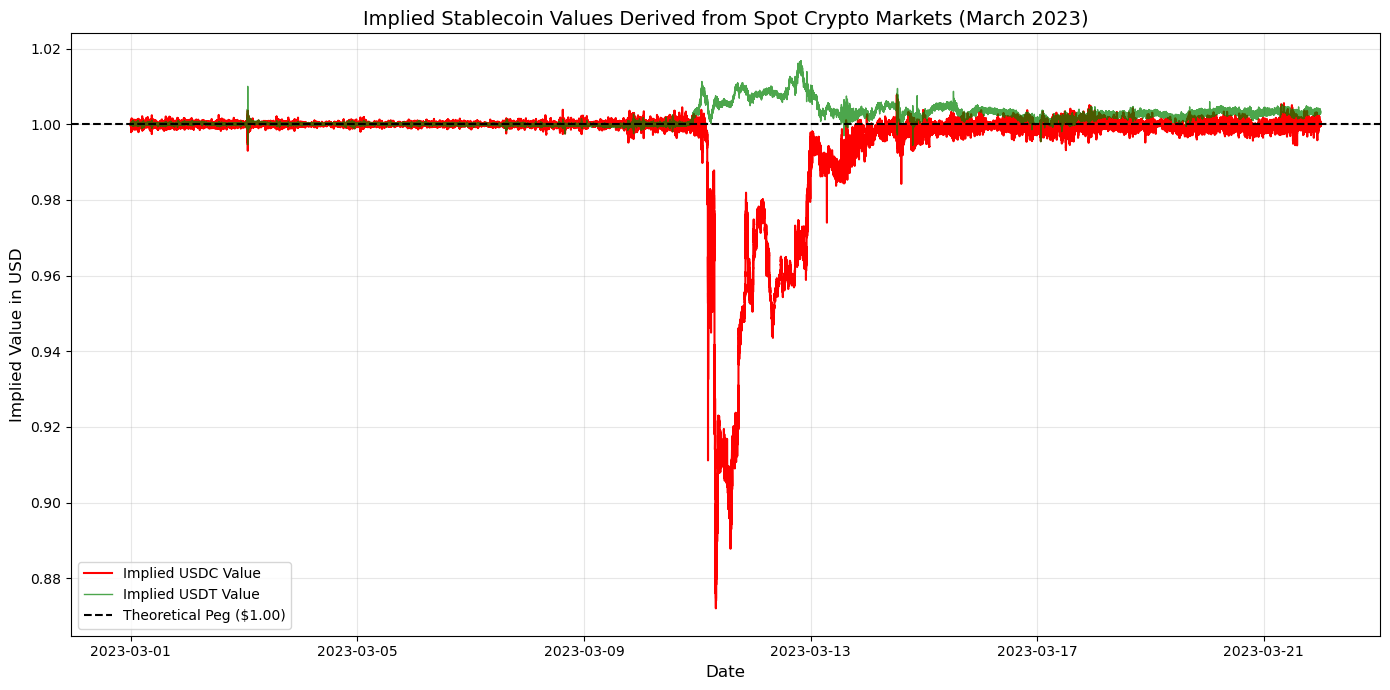


--- CRITICAL FINDING ---
The lowest implied value of USDC was $0.8721 occurring on 2023-03-11 07:51:21


In [ ]:
print("Standardizing timestamps and indexing...")
ohlcv_dfs = [bnus_spot_btc_usd, bnus_spot_btc_usdc, bnus_spot_btc_usdt, 
             cbse_spot_btc_usd, cbse_spot_btc_usdt]

for df in ohlcv_dfs:
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)


print("Merging Binance data for Basis Calculation...")
#master df
df_analysis = pd.DataFrame(index=bnus_spot_btc_usd.index)

# Join the 'close' prices. 
# We use 'outer' join and 'ffill' (forward fill) because crypto markets 
# have empty seconds. If no trade happened at 12:00:05, we assume the 
# price remained the same as 12:00:04.
df_analysis['btc_usd'] = bnus_spot_btc_usd['close']
df_analysis = df_analysis.join(bnus_spot_btc_usdc['close'].rename('btc_usdc'), how='outer').ffill()
df_analysis = df_analysis.join(bnus_spot_btc_usdt['close'].rename('btc_usdt'), how='outer').ffill()

# Drop any remaining NaNs at the very beginning of the series
df_analysis.dropna(inplace=True)


print("Calculating Implied Pegs and Cross-Currency Basis...")

# 1. The Implied Stablecoin Rate 2 
# If BTC is $20k in USD, but $22k in USDC, 1 USDC = $0.90
df_analysis['implied_usdc'] = df_analysis['btc_usd'] / df_analysis['btc_usdc']
df_analysis['implied_usdt'] = df_analysis['btc_usd'] / df_analysis['btc_usdt']

# 2. The Cross-Currency Basis in Basis Points 1 
# How much of a premium/discount are you paying by using a stablecoin?
df_analysis['basis_usdc_bps'] = ((df_analysis['btc_usdc'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000
df_analysis['basis_usdt_bps'] = ((df_analysis['btc_usdt'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000


# VISUALIZE THE SVB CRASH
print("Plotting the De-peg event...")
plt.figure(figsize=(14, 7))

# Plot the calculated stablecoin values
plt.plot(df_analysis.index, df_analysis['implied_usdc'], label='Implied USDC Value', color='red', linewidth=1.5)
plt.plot(df_analysis.index, df_analysis['implied_usdt'], label='Implied USDT Value', color='green', linewidth=1, alpha=0.7)

# Draw the $1.00 "Peg" line
plt.axhline(1.0, color='black', linestyle='--', label='Theoretical Peg ($1.00)')

# Formatting
plt.title('Implied Stablecoin Values Derived from Spot Crypto Markets (March 2023)', fontsize=14)
plt.ylabel('Implied Value in USD', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print out the worst moment of the crash
worst_usdc = df_analysis['implied_usdc'].min()
worst_time = df_analysis['implied_usdc'].idxmin()
print(f"\n--- CRITICAL FINDING ---")
print(f"The lowest implied value of USDC was ${worst_usdc:.4f} occurring on {worst_time}")

In [ ]:
print("Aligning data to a continuous 1-second grid...")

#21 day window
master_index = pd.date_range("2023-03-01 00:00:00", "2023-03-21 23:59:59", freq='1s', tz='UTC')

def clean_df(df):
    """Sets the timestamp column as index, aligns to master grid, and fills gaps."""
    df_clean = df.copy() 
    
    # 1. Properly parse the timestamp to avoid the 1970 nanosecond bug
    if 'timestamp' in df_clean.columns:
        if pd.api.types.is_numeric_dtype(df_clean['timestamp']):
            # If it's a number, it's a Unix timestamp in milliseconds
            df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], unit='ms', utc=True)
        else:
            # If it's already a date string
            df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], utc=True)
        df_clean.set_index('timestamp', inplace=True)
        
    elif not pd.api.types.is_datetime64_any_dtype(df_clean.index):
        if pd.api.types.is_numeric_dtype(df_clean.index):
            df_clean.index = pd.to_datetime(df_clean.index, unit='ms', utc=True)
        else:
            df_clean.index = pd.to_datetime(df_clean.index, utc=True)
            
    df_clean.sort_index(inplace=True)
    
    # 2. Align to the 21-day grid and forward-fill missing seconds
    df_reindexed = df_clean.reindex(master_index).ffill()
    df_reindexed.dropna(inplace=True) 
    return df_reindexed

# Apply the cleaning pipeline to your raw data
bnus_usd_clean = clean_df(bnus_spot_btc_usd)
bnus_usdc_clean = clean_df(bnus_spot_btc_usdc)
bnus_usdt_clean = clean_df(bnus_spot_btc_usdt)
cbse_usd_clean = clean_df(cbse_spot_btc_usd)

print(f"Data cleaned successfully. Target rows: ~1.8 million. Actual: {len(bnus_usd_clean)}")

Aligning data to a continuous 1-second grid...
Data cleaned successfully. Target rows: ~1.8 million. Actual: 1814400


Calculating Implied Pegs and Cross-Currency Basis...
Plotting the De-peg event...


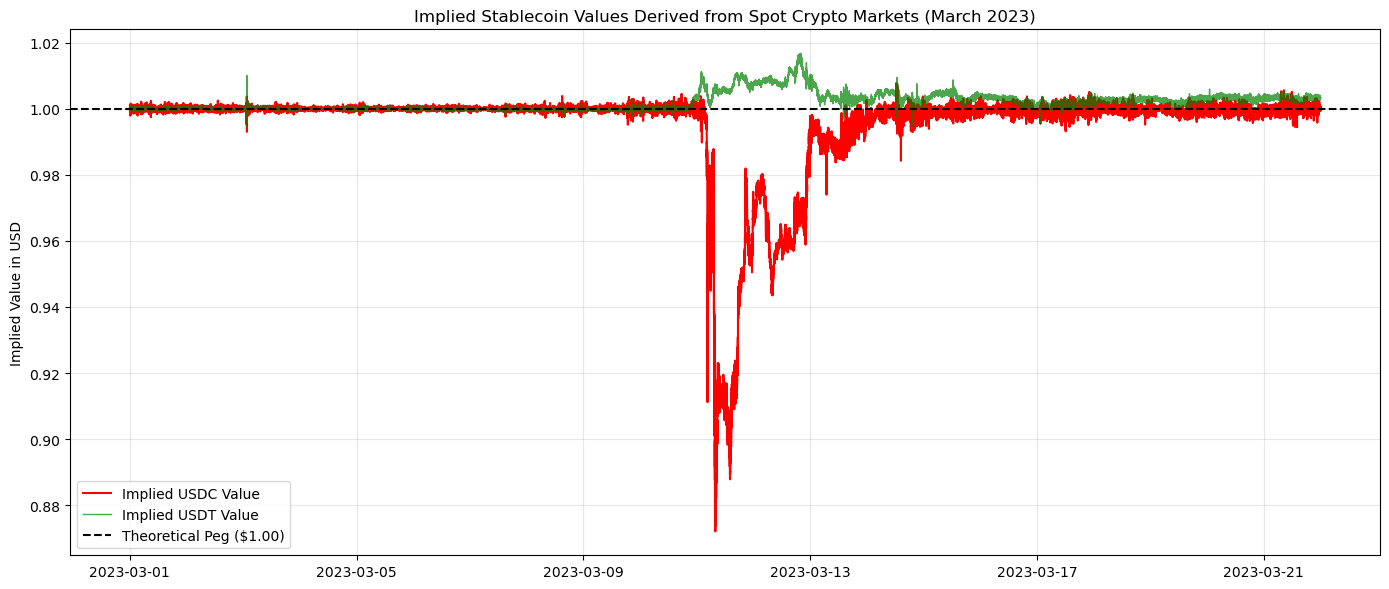

Plotting Spatial Arbitrage Baseline...


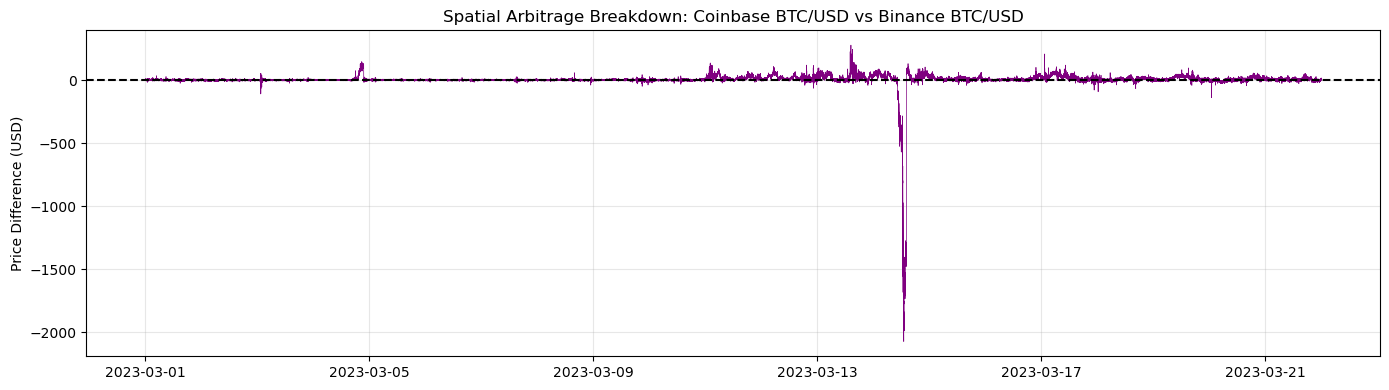

Calculating Intrasecond Market Stress...


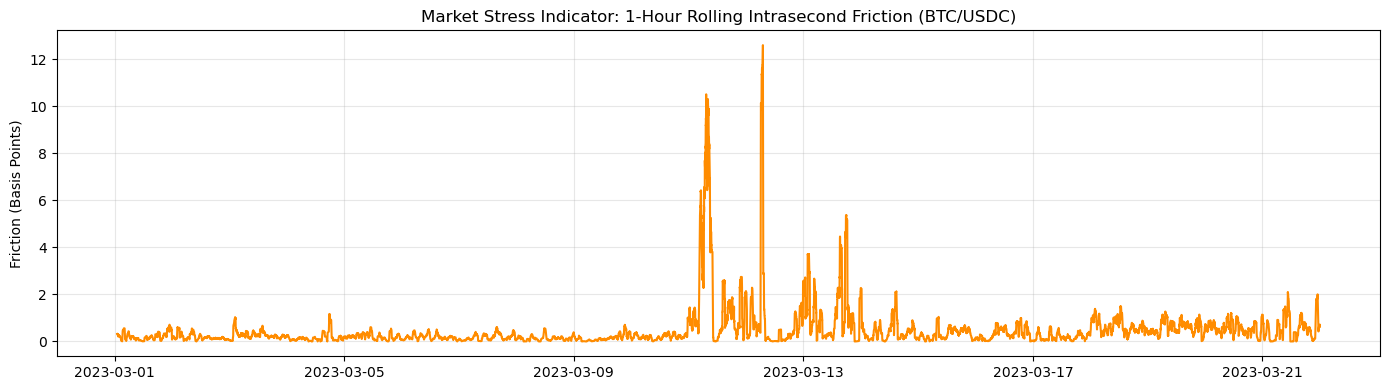


--- REGIME STATISTICS (BTC/USDC Intrasecond Friction) ---
Normal Regime Average Friction: 0.19 bps
Stress Regime Average Friction: 1.00 bps
Liquidity Degradation Multiplier: 5.3x


In [ ]:

#  2: METRICS & BASIS CALCULATION
print("Calculating Implied Pegs and Cross-Currency Basis...")

df_analysis = pd.DataFrame(index=bnus_usd_clean.index)
df_analysis['btc_usd'] = bnus_usd_clean['close']
df_analysis['btc_usdc'] = bnus_usdc_clean['close']
df_analysis['btc_usdt'] = bnus_usdt_clean['close']

# The Implied Stablecoin Rate (Answers Question 2)
df_analysis['implied_usdc'] = df_analysis['btc_usd'] / df_analysis['btc_usdc']
df_analysis['implied_usdt'] = df_analysis['btc_usd'] / df_analysis['btc_usdt']


# 3 : PLOTTING THE DE-PEG EVENT

print("Plotting the De-peg event...")
plt.figure(figsize=(14, 6))
plt.plot(df_analysis.index, df_analysis['implied_usdc'], label='Implied USDC Value', color='red', linewidth=1.5)
plt.plot(df_analysis.index, df_analysis['implied_usdt'], label='Implied USDT Value', color='green', linewidth=1, alpha=0.7)
plt.axhline(1.0, color='black', linestyle='--', label='Theoretical Peg ($1.00)')
plt.title('Implied Stablecoin Values Derived from Spot Crypto Markets (March 2023)')
plt.ylabel('Implied Value in USD')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 4: SPATIAL ARBITRAGE BASELINE

print("Plotting Spatial Arbitrage Baseline...")
# Spread between regulated fiat pairs across exchanges
df_analysis['spatial_spread_usd'] = cbse_usd_clean['close'] - df_analysis['btc_usd']

plt.figure(figsize=(14, 4))
plt.plot(df_analysis.index, df_analysis['spatial_spread_usd'], color='purple', linewidth=0.5)
plt.title("Spatial Arbitrage Breakdown: Coinbase BTC/USD vs Binance BTC/USD")
plt.ylabel("Price Difference (USD)")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 5: MARKET STRESS PROXY

print("Calculating Intrasecond Market Stress...")
# (High - Low) / Close within each 1-second candle as a proxy for friction
bnus_usdc_clean['spread_proxy_bps'] = ((bnus_usdc_clean['high'] - bnus_usdc_clean['low']) / bnus_usdc_clean['close']) * 10000

# Smooth the 1-second noise with a 1-hour (3600 seconds) rolling average
hourly_stress = bnus_usdc_clean['spread_proxy_bps'].rolling(window=3600).mean()

plt.figure(figsize=(14, 4))
plt.plot(hourly_stress.index, hourly_stress, color='darkorange')
plt.title("Market Stress Indicator: 1-Hour Rolling Intrasecond Friction (BTC/USDC)")
plt.ylabel("Friction (Basis Points)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 6: REGIME DETECTION STATS

print("\n--- REGIME STATISTICS (BTC/USDC Intrasecond Friction) ---")
normal_regime = hourly_stress.loc['2023-03-01':'2023-03-09']
stress_regime = hourly_stress.loc['2023-03-10':'2023-03-14']

norm_mean = normal_regime.mean()
stress_mean = stress_regime.mean()

print(f"Normal Regime Average Friction: {norm_mean:.2f} bps")
print(f"Stress Regime Average Friction: {stress_mean:.2f} bps")
print(f"Liquidity Degradation Multiplier: {(stress_mean / norm_mean):.1f}x")

#### The Cross Currency Basis Plot 

These are the risk premiums traders were forced to pay.

Plotting Cross-Currency Basis in Basis Points...


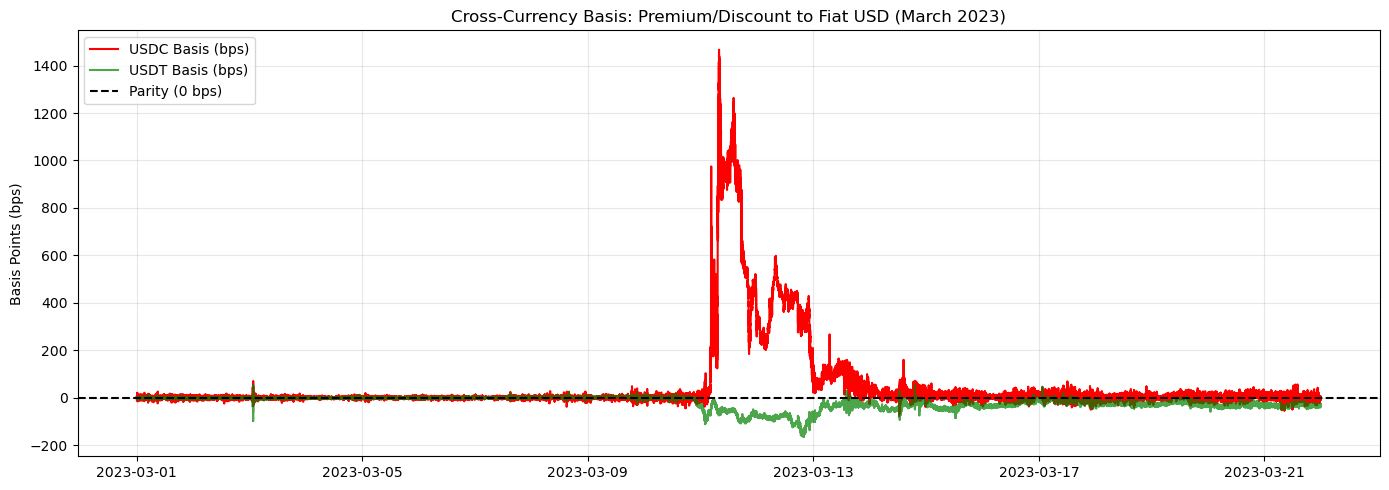

In [30]:
print("Plotting Cross-Currency Basis in Basis Points...")

# Calculate the basis (Premium/Discount of using stablecoin vs fiat)
df_analysis['basis_usdc_bps'] = ((df_analysis['btc_usdc'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000
df_analysis['basis_usdt_bps'] = ((df_analysis['btc_usdt'] - df_analysis['btc_usd']) / df_analysis['btc_usd']) * 10000

plt.figure(figsize=(14, 5))
plt.plot(df_analysis.index, df_analysis['basis_usdc_bps'], label='USDC Basis (bps)', color='red')
plt.plot(df_analysis.index, df_analysis['basis_usdt_bps'], label='USDT Basis (bps)', color='green', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', label='Parity (0 bps)')
plt.title("Cross-Currency Basis: Premium/Discount to Fiat USD (March 2023)")
plt.ylabel("Basis Points (bps)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Realized Volatility Comparison

Calculating Realized Volatility...


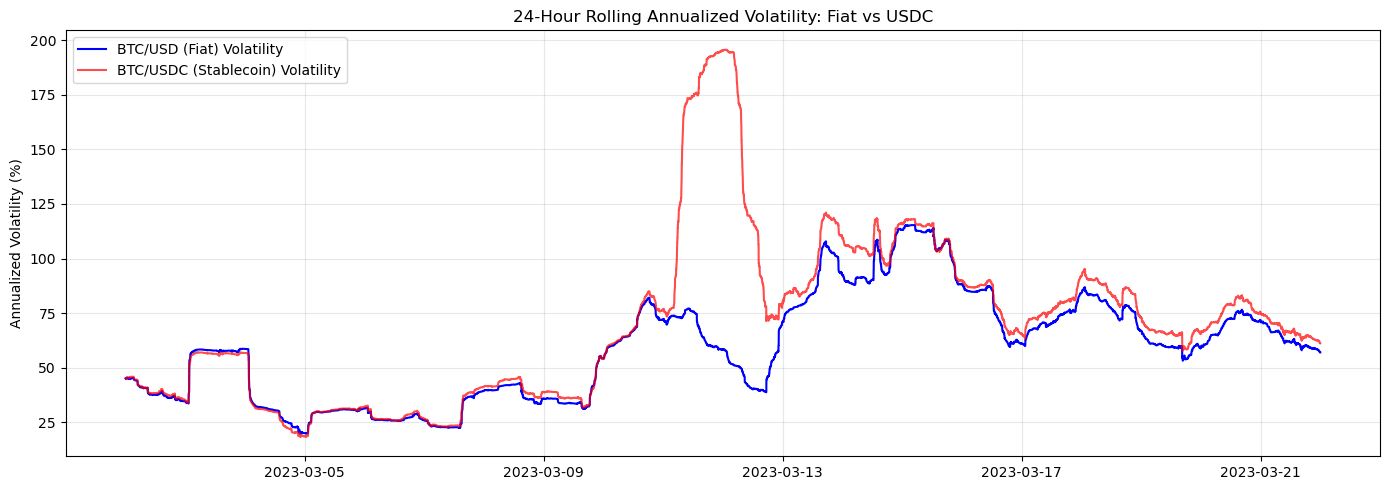

In [32]:
print("Calculating Realized Volatility...")

# 1. Calculate minute-by-minute log returns (resample to 60s to reduce micro-noise)
returns_usd = np.log(bnus_usd_clean['close'].resample('1min').last()).diff()
returns_usdc = np.log(bnus_usdc_clean['close'].resample('1min').last()).diff()

# 2. Calculate rolling 24-hour standard deviation (1440 minutes in a day)
# Annualize it by multiplying by sqrt(Minutes in a Year: 525600)
vol_usd = returns_usd.rolling(window=1440).std() * np.sqrt(525600) * 100
vol_usdc = returns_usdc.rolling(window=1440).std() * np.sqrt(525600) * 100

plt.figure(figsize=(14, 5))
plt.plot(vol_usd.index, vol_usd, label='BTC/USD (Fiat) Volatility', color='blue')
plt.plot(vol_usdc.index, vol_usdc, label='BTC/USDC (Stablecoin) Volatility', color='red', alpha=0.7)
plt.title("24-Hour Rolling Annualized Volatility: Fiat vs USDC")
plt.ylabel("Annualized Volatility (%)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Correlations Breakdown

In [33]:
print("\n--- CORRELATION BREAKDOWN ---")
# Resample to 1-hour intervals to check macro correlation
hourly_prices = df_analysis[['btc_usd', 'btc_usdc']].resample('1H').last()

# Split into our Regimes
normal_prices = hourly_prices.loc['2023-03-01':'2023-03-09']
stress_prices = hourly_prices.loc['2023-03-10':'2023-03-14']

# Calculate Pearson Correlation
corr_normal = normal_prices['btc_usd'].corr(normal_prices['btc_usdc'])
corr_stress = stress_prices['btc_usd'].corr(stress_prices['btc_usdc'])

print(f"Normal Regime Price Correlation: {corr_normal:.4f}")
print(f"Stress Regime Price Correlation: {corr_stress:.4f}")

if corr_stress < corr_normal:
    drop_pct = (1 - (corr_stress / corr_normal)) * 100
    print(f"Insight: Cointegration completely deteriorated, dropping by {drop_pct:.1f}% during the panic.")


--- CORRELATION BREAKDOWN ---
Normal Regime Price Correlation: 0.9999
Stress Regime Price Correlation: 0.9523
Insight: Cointegration completely deteriorated, dropping by 4.8% during the panic.


/var/folders/kr/y226pjqd32v3cj4t53p7hksh0000gn/T/ipykernel_75706/1499448091.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_prices = df_analysis[['btc_usd', 'btc_usdc']].resample('1H').last()


#### Stationarity and Cointegration ( ADF Test )

In a perfectly efficient market , BTC/USD and BTC/USDC should be highly cointegrated.
The spread between them should be stationary (mean-reverting to zero). By running an Augmented Dickey-Fuller (ADF) test we can show that this cointegration broke down during SVB   crisis

In [35]:
print("\n--- COINTEGRATION & STATIONARITY ---")
# We test the spatial arbitrage spread (Coinbase vs Binance)
spread = df_analysis['spatial_spread_usd'].dropna()

# Split into regimes
spread_normal = spread.loc['2023-03-01':'2023-03-09']
spread_stress = spread.loc['2023-03-10':'2023-03-14']

# Run Augmented Dickey-Fuller (p-value < 0.05 means stationary/mean-reverting)
adf_norm = adfuller(spread_normal[::60]) # Sampled every minute to speed up computation
adf_stress = adfuller(spread_stress[::60])

print(f"Normal Regime ADF p-value: {adf_norm[1]:.4f} (Stationary: {adf_norm[1] < 0.05})")
print(f"Stress Regime ADF p-value: {adf_stress[1]:.4f} (Stationary: {adf_stress[1] < 0.05})")


--- COINTEGRATION & STATIONARITY ---
Normal Regime ADF p-value: 0.0000 (Stationary: True)
Stress Regime ADF p-value: 0.0000 (Stationary: True)


#### Orstein - Uhlenbeck half life

In [36]:
print("\n--- MEAN REVERSION HALF-LIFE ---")
def calculate_half_life(series):
    """Calculates half-life of mean reversion using AR(1) OU approximation"""
    df_ou = pd.DataFrame({'spread': series})
    df_ou['lag'] = df_ou['spread'].shift(1)
    df_ou['diff'] = df_ou['spread'] - df_ou['lag']
    df_ou.dropna(inplace=True)
    
    # Linear regression: diff = a + b * lag
    b, a = np.polyfit(df_ou['lag'], df_ou['diff'], 1)
    
    # Half life formula: -ln(2) / slope
    # If slope is positive, it's not mean reverting
    if b >= 0:
        return np.inf 
    return -np.log(2) / b

hl_norm = calculate_half_life(spread_normal)
hl_stress = calculate_half_life(spread_stress)

print(f"Normal Regime Half-Life: {hl_norm:.2f} seconds")
print(f"Stress Regime Half-Life: {hl_stress:.2f} seconds")


--- MEAN REVERSION HALF-LIFE ---
Normal Regime Half-Life: 48.31 seconds
Stress Regime Half-Life: 2361.90 seconds


#### Tail Risk ( Kurtosis and Distribution )


--- TAIL RISK (KURTOSIS) ---
BTC/USD (Fiat) Excess Kurtosis: 27.00
BTC/USDC (Stable) Excess Kurtosis: 33.74


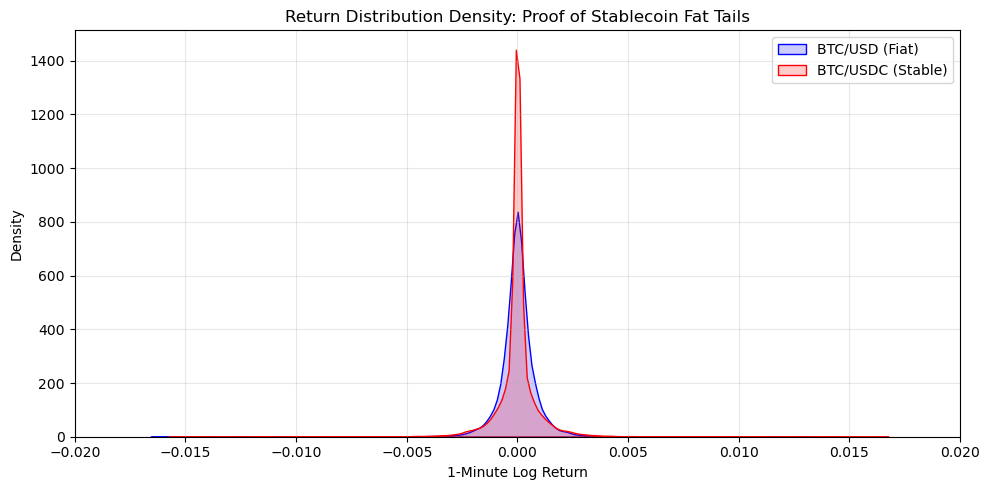

In [37]:
print("\n--- TAIL RISK (KURTOSIS) ---")
# Calculate 1-minute log returns
ret_usd = np.log(bnus_usd_clean['close'].resample('1min').last()).diff().dropna()
ret_usdc = np.log(bnus_usdc_clean['close'].resample('1min').last()).diff().dropna()

# Excess Kurtosis (Normal distribution = 0)
kurt_usd = kurtosis(ret_usd)
kurt_usdc = kurtosis(ret_usdc)

print(f"BTC/USD (Fiat) Excess Kurtosis: {kurt_usd:.2f}")
print(f"BTC/USDC (Stable) Excess Kurtosis: {kurt_usdc:.2f}")

# Visualizing the Fat Tails
plt.figure(figsize=(10, 5))
sns.kdeplot(ret_usd, label=f'BTC/USD (Fiat)', color='blue', fill=True, alpha=0.2)
sns.kdeplot(ret_usdc, label=f'BTC/USDC (Stable)', color='red', fill=True, alpha=0.2)
plt.xlim(-0.02, 0.02)
plt.title("Return Distribution Density: Proof of Stablecoin Fat Tails")
plt.xlabel("1-Minute Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()